# Detectando fake news

Realizar una clasificación automática de las noticias en veraces o no, permite reducir el número de noticias a revisar con criterio humano (fact-checking). 
Con unas pocas líneas de código, buscamos entrenar un modelo simple con este objetivo. Se parte de un conjunto de noticias etiquetadas como verdaderas o falsas, y se crea un sistema que aprende a diferenciarlas según el contenido del dataset.

## Leyendo y explorando la base

In [3]:
# Cargo las librerías que será utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [4]:
# Leo la base
os.getcwd() # Lo utilizo para conocer el directorio donde cargar el archivo
df = pd.read_csv('train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
# Para saber cuántos NaN hay en cada columna
df.isnull().sum() 

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
# Eliminamos las filas con na
df.dropna(inplace=True)

C:\Users\NoteBook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

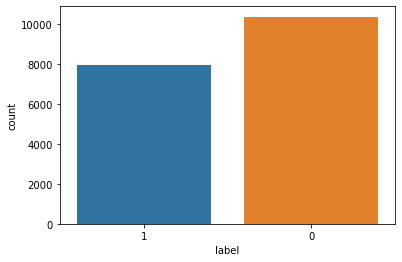

In [7]:
# Veo la distribución de las etiquetadas como fake news o no
df['label']=df['label'].astype(str)
sns.countplot(df['label'])

In [8]:
# Vamos a reiniciar los índices del df
messages=df.copy()
messages.reset_index(inplace=True)
messages.drop(['index','id'],axis=1,inplace=True)
messages.head()

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Preparando y procesando la data

In [9]:
# La matemáticas solo reconoce los números no el texto, por lo que hay que procesar la data
# Primero muestro las transformaciones en una sola observación
data=messages['title'][0]
data # Hay muchos carácteres especiales

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [10]:
# Elimino los carácteres especiales
re.sub('[^a-zA-Z]',' ', data)

'House Dem Aide  We Didn t Even See Comey s Letter Until Jason Chaffetz Tweeted It'

In [11]:
# Paso todo a minúsculas
data=data.lower()
data

'house dem aide: we didn’t even see comey’s letter until jason chaffetz tweeted it'

In [12]:
# Separo las palabras
list=data.split()
list

['house',
 'dem',
 'aide:',
 'we',
 'didn’t',
 'even',
 'see',
 'comey’s',
 'letter',
 'until',
 'jason',
 'chaffetz',
 'tweeted',
 'it']

In [13]:
!pip install nltk

In [14]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [15]:
ps=PorterStemmer()

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NoteBook\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# Realizo el "stemming", me quedo solo con la raiz de las palabras
review=[]
for word in list:
    if word not in set(stopwords.words('english')):
        review.append(ps.stem(word))
review

['hous',
 'dem',
 'aide:',
 'didn’t',
 'even',
 'see',
 'comey’',
 'letter',
 'jason',
 'chaffetz',
 'tweet']

In [18]:
' '.join(review)

'hous dem aide: didn’t even see comey’ letter jason chaffetz tweet'

In [19]:
# Aplico este procedimiento a todas las filas
corpus=[]
sentences=[]
for i in range(0,len(messages)):
    review=re.sub('[^a-zA-Z]',' ', messages['title'][i])
    review=review.lower()
    list=review.split()
    review=[ps.stem(word) for word in list if word not in set(stopwords.words('english'))]
    sentences=' '.join(review)
    corpus.append(sentences)

## Aplicando un modelo bolsa de palabras

In [20]:
# Tenemos que usar alguna técnica de NLP que transforma el texto en vectores
# Countvectorizer crea un modelo del tipo bolsa de palabras
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
# Quiero el top 50000 de los features 
# Que pruebe combinaciones de 1, 2 y 3 palabras
cv=CountVectorizer(max_features=5000,ngram_range=(1,3))

In [22]:
# Genero los features
X = cv.fit_transform(corpus).toarray()

In [23]:
cv.get_feature_names()[0:20]

['abandon',
 'abc',
 'abc news',
 'abduct',
 'abe',
 'abedin',
 'abl',
 'abort',
 'abroad',
 'absolut',
 'abstain',
 'absurd',
 'abus',
 'abus new',
 'abus new york',
 'academi',
 'accept',
 'access',
 'access pipelin',
 'access pipelin protest']

In [24]:
# Asigno los labels a Y
y = messages['label']

In [25]:
# Dividimos el dataset entre entrenamiento y testeo
from sklearn.model_selection import train_test_split
# Recordar que random_state funciona como semilla
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25, random_state=42)

## Aplicando Bayes

In [26]:
# Este algoritmo clasificador funciona bien con texto
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

In [27]:
classifier.fit(X_train,y_train)

MultinomialNB()

In [28]:
pred=classifier.predict(X_test)
pred

array(['1', '0', '0', ..., '0', '0', '0'], dtype='<U1')

In [29]:
# Ahora quiero saber su precisión
from sklearn import metrics
metrics.accuracy_score(y_test,pred)

0.8904199475065617

In [30]:
cm=metrics.confusion_matrix(y_test,pred)
cm

array([[2301,  299],
       [ 202, 1770]], dtype=int64)

([<matplotlib.axis.YTick at 0x208e5cb9790>,
 [Text(0, 0, 'positivo'), Text(0, 1, 'negativo')])

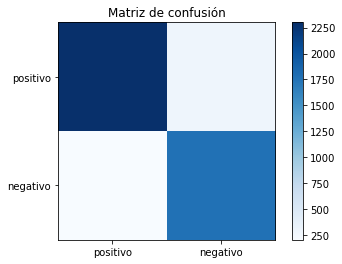

In [31]:
# Una matriz de confusión más amigable
plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Matriz de confusión')
labels=['positivo','negativo']
tick_marks=np.arange(len(labels))
plt.xticks(tick_marks,labels)
plt.yticks(tick_marks,labels)

## Aplicando un Passive Aggressive Classifier

In [32]:
# Este algoritmo clasificador también funciona bien con texto
from sklearn.linear_model import PassiveAggressiveClassifier

In [33]:
linear_clf = PassiveAggressiveClassifier()

In [34]:
linear_clf.fit(X_train,y_train) # Utilizo los parámetros por default

PassiveAggressiveClassifier()

In [35]:
predictions = linear_clf.predict(X_test)

In [36]:
# Ahora quiero saber su precisión
metrics.accuracy_score(y_test,predictions)

0.9111986001749781

In [37]:
cm2=metrics.confusion_matrix(y_test,predictions)
cm2

array([[2351,  249],
       [ 157, 1815]], dtype=int64)

([<matplotlib.axis.YTick at 0x208e6498880>,
 [Text(0, 0, 'positivo'), Text(0, 1, 'negativo')])

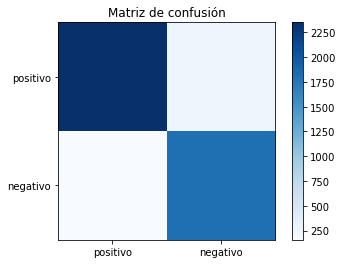

In [38]:
# También grafico la matriz de confusión
plt.imshow(cm2,interpolation='nearest',cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Matriz de confusión')
labels=['positivo','negativo']
tick_marks=np.arange(len(labels))
plt.xticks(tick_marks,labels)
plt.yticks(tick_marks,labels)

In [39]:
# Obtengo las palabras (features)
feature_names = cv.get_feature_names()

In [40]:
# Las palabras más asociadas a fake news
sorted(zip(classifier.coef_[0],feature_names),reverse=True)[0:20]

C:\Users\NoteBook\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


[(-3.9648951809317863, 'trump'),
 (-4.272721819476034, 'hillari'),
 (-4.368759007672977, 'clinton'),
 (-4.861090048802803, 'elect'),
 (-5.219261999009128, 'new'),
 (-5.230561554263062, 'comment'),
 (-5.269176390390841, 'video'),
 (-5.355472203843678, 'war'),
 (-5.372788653855138, 'hillari clinton'),
 (-5.394864605554338, 'us'),
 (-5.412883111057016, 'fbi'),
 (-5.483500678270969, 'vote'),
 (-5.483500678270969, 'email'),
 (-5.559486585248892, 'obama'),
 (-5.570068694579429, 'world'),
 (-5.718914322176994, 'donald'),
 (-5.743915624382411, 'donald trump'),
 (-5.8229040357010415, 'russia'),
 (-5.864868234800074, 'presid'),
 (-5.872036724278686, 'america')]